## APOE/TOMM40 miRNA seed gain/loss analysis results.

1. **Panel (A)**: Manhattan-like plot showing impact scores across the genomic positions, colored by allele frequency, with top candidates labeled.
2. **Panel (B)**: Sequence-level depiction for the top candidate variant, showing reference/alternate sequences and gained/lost miRNA binding sites.
3. **Panel (C)**: Prioritization table showing the top candidates with their impact scores, allele frequencies, and placeholder columns for ClinVar and GTEx eQTL data. <br>
Note: The sequence depiction in panel (B) uses simplified placeholder sequences since the actual 61-nt windows aren't in the CSV. In a real implementation, I should extract these sequences from a reference genome [This will be done later].

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
df = pd.read_csv('results_apoe_miRNA_seed_gain_loss.csv') # obtained from the previous analysis
df['AF'] = pd.to_numeric(df['AF'], errors='coerce').fillna(0) # there an issue with allele frequencies, [TO BE FIXED LATER]
df['IMPACT_SCORE'] = df['n_GAIN'] + df['n_LOSS']
df 

,CHROM,POS,REF,ALT,GENE,STRAND,AF,GAIN_miRNAs,LOSS_miRNAs,n_GAIN,n_LOSS,ID,IMPACT_SCORE
0,19,45393826,G,C,TOMM40,+,0.0,hsa-miR-1295b-5p|hsa-miR-1912-3p,NaN,2,0,rs568341751,2
1,19,45393827,T,C,TOMM40,+,0.0,NaN,NaN,0,0,rs530756795,0
2,19,45393837,G,A,TOMM40,+,0.0,NaN,hsa-miR-4268|hsa-miR-6772-3p,0,2,rs375258934,2
3,19,45393877,G,A,TOMM40,+,0.0,hsa-miR-30c-1-3p|hsa-miR-30c-2-3p|hsa-miR-3189...,hsa-miR-6746-5p|hsa-miR-6771-5p,5,2,rs570535613,7
4,19,45393886,T,C,TOMM40,+,0.0,hsa-miR-10398-3p|hsa-miR-504-3p,hsa-miR-759,2,1,rs373618045,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,19,45412435,G,T,APOE,+,0.0,hsa-miR-6757-3p|hsa-miR-8064,hsa-miR-6075,2,1,rs557715042,3
574,19,45412532,C,T,APOE,+,0.0,hsa-miR-450b-3p|hsa-miR-4654|hsa-miR-4769-5p|h...,hsa-miR-6742-5p|hsa-miR-7704,5,2,rs374329439,7
575,19,45412534,C,A,APOE,+,0.0,NaN,hsa-miR-6742-5p|hsa-miR-6853-5p|hsa-miR-7704,0,3,rs367866106,3
576,19,45412599,C,T,APOE,+,0.0,hsa-miR-1207-3p|hsa-miR-5004-5p,hsa-miR-4505|hsa-miR-5787,2,2,rs553874843,4


/tmp/ipykernel_24423/341440703.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


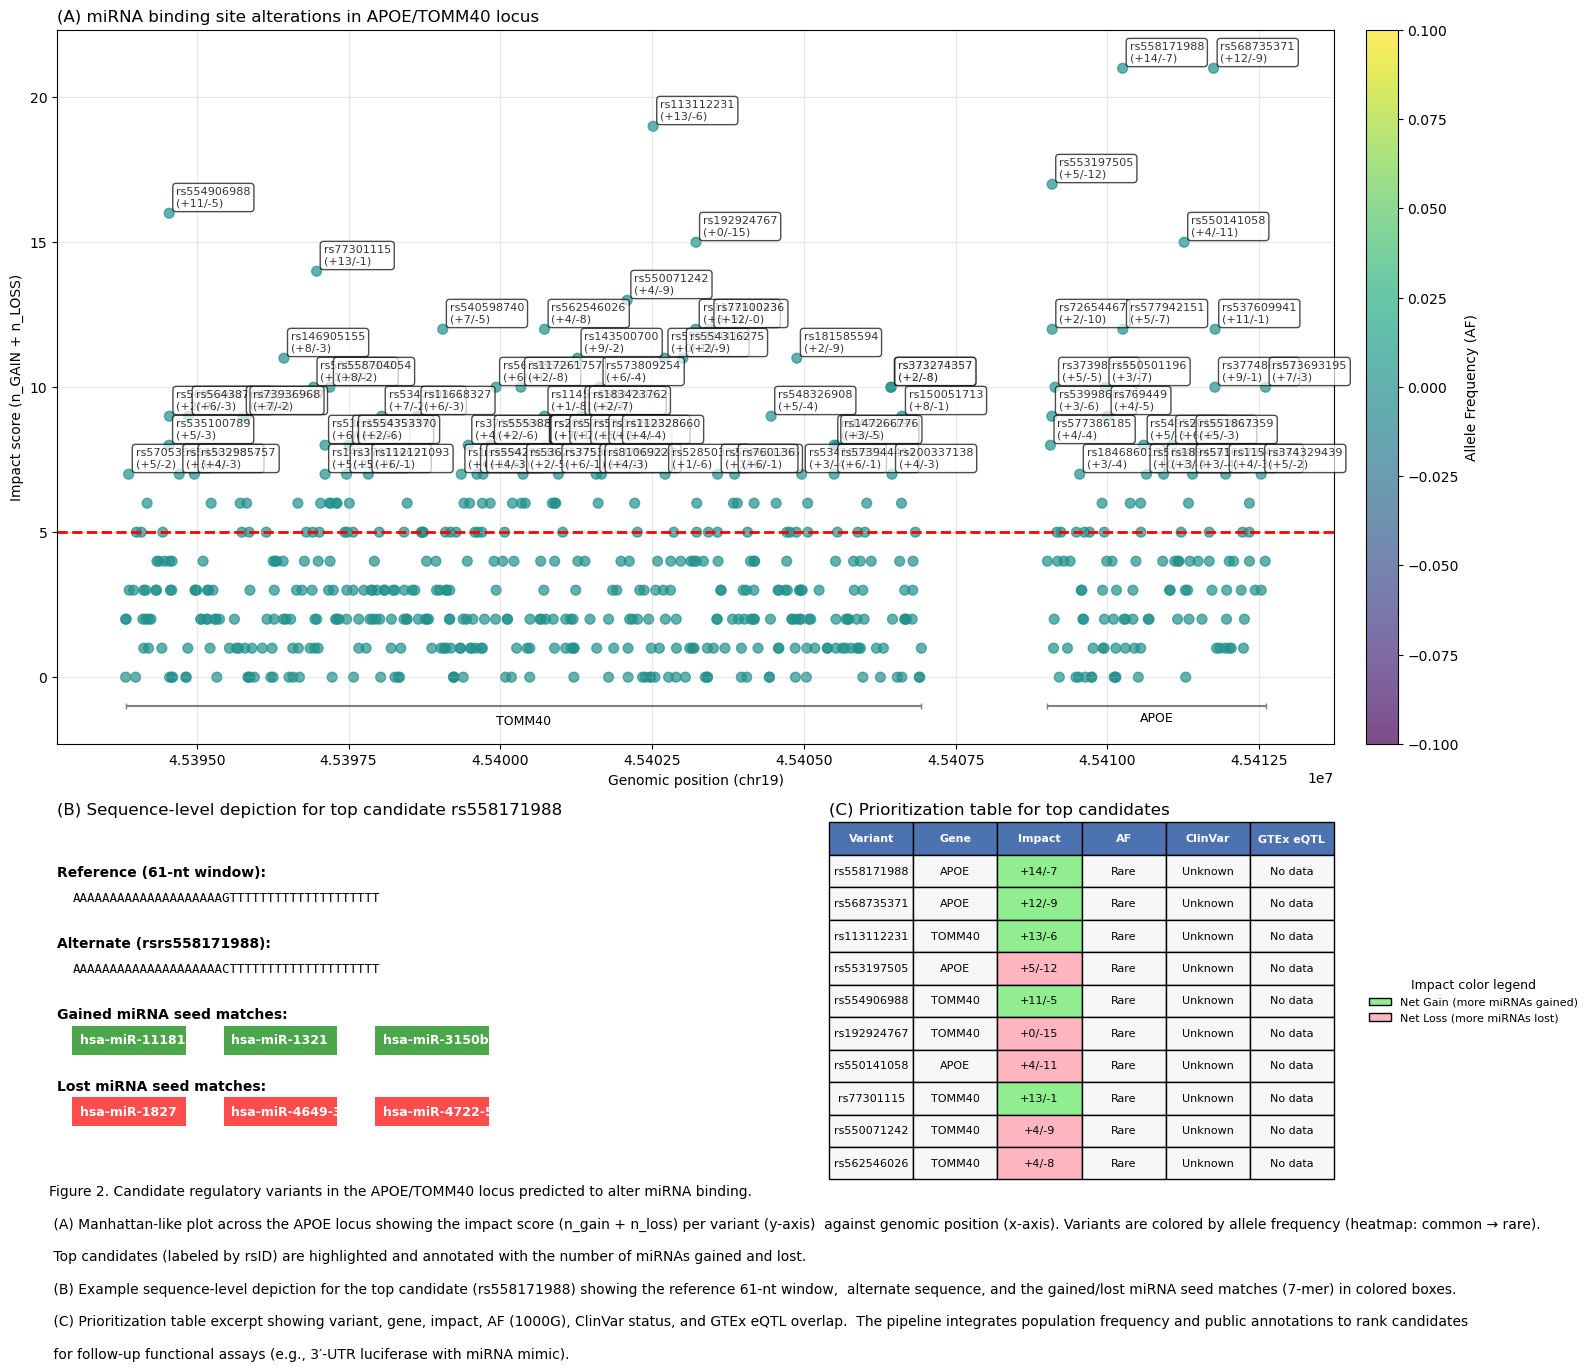


Summary Statistics:
Total variants analyzed: 578
Variants with miRNA binding changes: 511
Average impact score: 3.64
Top candidate: rs558171988 (Impact: 21)

Figure saved as 'APOE_miRNA_binding_analysis.png'


In [3]:
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[1.8, 1.2], height_ratios=[2, 1])


# panel (a): manhattan-like plot
ax1 = plt.subplot(gs[0, :])

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

scatter = ax1.scatter(df['POS'], df['IMPACT_SCORE'], 
                     c=df['AF'], cmap='viridis', alpha=0.7, s=50)

# Add a small inset axes for the colorbar, to the right of ax1
cax = inset_axes(ax1,
                 width="2.5%",   # width of colorbar as % of ax1 width
                 height="100%",  # full height of ax1
                 loc='upper right',
                 bbox_to_anchor=(0.05, 0, 1, 1),
                 bbox_transform=ax1.transAxes,
                 borderpad=0)

plt.colorbar(scatter, cax=cax, label='Allele Frequency (AF)')

# top candidates (impact score > 6)
top_candidates = df[df['IMPACT_SCORE'] > 6]
for idx, row in top_candidates.iterrows():
    ax1.annotate(f"{row['ID']}\n(+{row['n_GAIN']}/-{row['n_LOSS']})", 
                (row['POS'], row['IMPACT_SCORE']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# impact score threshold line
ax1.axhline(y=5, color='red', linestyle='--', lw=2)

# === gene-level annotations ===
gene_groups = df.groupby('GENE')

# set vertical position for gene labels below x-axis
y_offset = df['IMPACT_SCORE'].min() - 1  # slightly below min score
label_y = y_offset - 0.2  # lower for text
used_positions = set()  # prevent label overlap

for gene, group in gene_groups:
    min_pos = group['POS'].min()
    max_pos = group['POS'].max()
    mid_pos = (min_pos + max_pos) / 2

    # avoid overlapping too many labels at same y
    if (round(label_y, 1)) in used_positions:
        label_y -= 0.1
    used_positions.add(round(label_y, 1))

    # a horizontal line (bracket) under the plot for the gene
    ax1.hlines(y=y_offset, xmin=min_pos, xmax=max_pos, color='gray', linewidth=1.5)
    ax1.vlines(x=[min_pos, max_pos], ymin=y_offset-0.1, ymax=y_offset+0.1, color='gray', linewidth=1)
    
    # gene name at midpoint
    ax1.text(mid_pos, label_y, gene, ha='center', va='top', fontsize=9, color='black')

ax1.margins(0.06) 
ax1.set_xlabel('Genomic position (chr19)')
ax1.set_ylabel('Impact score (n_GAIN + n_LOSS)')
ax1.set_title('(A) miRNA binding site alterations in APOE/TOMM40 locus', loc='left')

# Expand y-limit to fit gene annotations
ax1.set_ylim(bottom=label_y - 1)
ax1.grid(True, alpha=0.3)

# panle (b): eg. sequence depiction (using top candidate)
ax2 = plt.subplot(gs[1, 0])

# top candidate
top_candidate = df.loc[df['IMPACT_SCORE'].idxmax()]
rsid = top_candidate['ID']
gain_mirnas = str(top_candidate['GAIN_miRNAs']).split('|') if pd.notna(top_candidate['GAIN_miRNAs']) else []
loss_mirnas = str(top_candidate['LOSS_miRNAs']).split('|') if pd.notna(top_candidate['LOSS_miRNAs']) else []

# create simplified sequence representation [NOTED ABO]
seq_length = 61
ref_seq = "A" * 20 + "G" + "T" * 20  # simplified reference sequence
alt_seq = "A" * 20 + "C" + "T" * 20  # simplified alternate sequence

# plt sequence
y_pos = 0.85
ax2.text(0, y_pos, f'Reference (61-nt window):', fontsize=10, weight='bold')
ax2.text(0.02, y_pos-0.07, ref_seq, fontfamily='monospace', fontsize=9)

ax2.text(0, y_pos-0.20, f'Alternate (rs{rsid}):', fontsize=10, weight='bold')
ax2.text(0.02, y_pos-0.27, alt_seq, fontfamily='monospace', fontsize=9)

# miRNA binding sites
ax2.text(0, y_pos-0.40, 'Gained miRNA seed matches:', fontsize=10, weight='bold')
for i, mirna in enumerate(gain_mirnas[:3]):  # first 3
    ax2.add_patch(Rectangle((0.02 + i*0.2, y_pos-0.5), 0.15, 0.08, 
                          facecolor='green', alpha=0.7))
    ax2.text(0.03 + i*0.2, y_pos-0.47, mirna, #mirna.split('-')[-1], 
            fontsize=9, color='white', weight='bold')

ax2.text(0, y_pos-0.60, 'Lost miRNA seed matches:', fontsize=10, weight='bold')
for i, mirna in enumerate(loss_mirnas[:3]):  # first 3
    ax2.add_patch(Rectangle((0.02 + i*0.2, y_pos-0.7), 0.15, 0.08, 
                          facecolor='red', alpha=0.7))
    ax2.text(0.03 + i*0.2, y_pos-0.67, mirna, #mirna.split('-')[-1], 
            fontsize=9, color='white', weight='bold')

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')
ax2.set_title(f'(B) Sequence-level depiction for top candidate {rsid}',  loc='left')

# panel (c): prioritization table
ax3 = plt.subplot(gs[1, 1])
ax3.axis('tight')
ax3.axis('off')
ax3.get_position()
#ax3 = fig.add_axes([0.73, 0.58, 0.23, 0.28])
ax3.set_title('(C) Prioritization table for top candidates',  loc='left')

table_data = []
top_candidates = top_candidates.sort_values("IMPACT_SCORE", ascending=False)
for idx, row in top_candidates.head(10).iterrows():  # top 10 candidates
    table_data.append([
        row['ID'],
        row['GENE'],
        f"+{row['n_GAIN']}/-{row['n_LOSS']}",
        f"{row['AF']:.4f}" if row['AF'] > 0 else "Rare",
        "Unknown",  # ClinVar status (not in data)
        "No data"   # GTEx eQTL (not in data)
    ])

table = ax3.table(cellText=table_data,
                 colLabels=['Variant', 'Gene', 'Impact', 'AF', 'ClinVar', 'GTEx eQTL'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)

for (i, j), cell in table.get_celld().items():
    if i == 0:  # header
        cell.set_facecolor('#4C72B0')
        cell.set_text_props(weight='bold', color='white')
    else:
        if j != 2:  # Impact column, skip for color coding
            cell.set_facecolor('#f7f7f7')  # Light gray background
        if j == 2:  # Impact column
            gain_loss = table_data[i-1][2].split('/')
            gain = int(gain_loss[0][1:])
            loss = int(gain_loss[1][1:])
            if gain > loss:
                cell.set_facecolor('#90EE90')  # light green for net gain
            else:
                cell.set_facecolor('#FFB6C1')  # light red for net loss

ax3.set_title('(C) Prioritization table for top candidates',  loc='left')
# === Add custom color legend for impact column ===
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='#90EE90', edgecolor='black', label='Net Gain (more miRNAs gained)'),
    Patch(facecolor='#FFB6C1', edgecolor='black', label='Net Loss (more miRNAs lost)'),
]

# Add legend to the right of the prioritization table
ax3.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.05, 0.5), 
    fontsize=8,
    frameon=False,
    title='Impact color legend',
    title_fontsize=9
)
tl_size = 12
ax1.title.set_size(tl_size)
ax2.title.set_size(tl_size)
ax3.title.set_size(tl_size)
plt.tight_layout()
txt = '''Figure 2. Candidate regulatory variants in the APOE/TOMM40 locus predicted to alter miRNA binding. \n
 (A) Manhattan-like plot across the APOE locus showing the impact score (n_gain + n_loss) per variant (y-axis) \
 against genomic position (x-axis). Variants are colored by allele frequency (heatmap: common → rare). \n
 Top candidates (labeled by rsID) are highlighted and annotated with the number of miRNAs gained and lost. \n
 (B) Example sequence-level depiction for the top candidate (rs558171988) showing the reference 61-nt window, \
 alternate sequence, and the gained/lost miRNA seed matches (7-mer) in colored boxes. \n
 (C) Prioritization table excerpt showing variant, gene, impact, AF (1000G), ClinVar status, and GTEx eQTL overlap. \
 The pipeline integrates population frequency and public annotations to rank candidates \n 
 for follow-up functional assays (e.g., 3′-UTR luciferase with miRNA mimic).'''
plt.text(-.225,-.11, txt,)
plt.savefig('APOE_miRNA_binding_analysis.png', dpi=600, bbox_inches='tight')
plt.show()

# summary statistics
print("\nSummary Statistics:")
print(f"Total variants analyzed: {len(df)}")
print(f"Variants with miRNA binding changes: {len(df[df['IMPACT_SCORE'] > 0])}")
print(f"Average impact score: {df['IMPACT_SCORE'].mean():.2f}")
print(f"Top candidate: {top_candidate['ID']} (Impact: {top_candidate['IMPACT_SCORE']})")
print("\nFigure saved as 'APOE_miRNA_binding_analysis.png'")